In [1]:
!pip -q install nltk gensim datasets scikit-learn matplotlib tqdm kagglehub


[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os, re, json, random
import numpy as np
import pandas as pd
from collections import Counter
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cpu')

In [3]:
df = None

try:
    import kagglehub
    from kagglehub import KaggleDatasetAdapter

    file_path = "IMDB Dataset.csv"
    df = kagglehub.load_dataset(
      KaggleDatasetAdapter.PANDAS,
      "lakshmi25npathi/imdb-dataset-of-50k-movie-reviews",
      file_path,
    )
    df = df.rename(columns={"review": "text"}) if "review" in df.columns else df
    print("Loaded via KaggleHub:", df.shape)

except Exception as e:
    print("KaggleHub load failed, trying HuggingFace datasets... (reason:", str(e)[:120], ")")
    from datasets import load_dataset
    ds = load_dataset("imdb")
    df = pd.concat([
        pd.DataFrame({"text": ds["train"]["text"], "label": ds["train"]["label"]}),
        pd.DataFrame({"text": ds["test"]["text"],  "label": ds["test"]["label"]}),
    ], ignore_index=True)
    print("Loaded via datasets:", df.shape)

if "sentiment" in df.columns and "label" not in df.columns:
    df["label"] = df["sentiment"].map({"negative": 0, "positive": 1}).astype(int)
if "review" in df.columns and "text" not in df.columns:
    df = df.rename(columns={"review": "text"})

df = df[["text","label"]].dropna().reset_index(drop=True)
df.head()

C:\Users\Joud\AppData\Local\Temp\ipykernel_3216\4119694464.py:8: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Loaded via KaggleHub: (50000, 2)


,text,label
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [4]:
import nltk
from nltk.tokenize import word_tokenize

try:
    nltk.download("punkt", quiet=True)
except Exception as e:
    print("NLTK download warning:", e)

def preprocess_text(text: str):
    text = str(text).lower()
    text = re.sub(r"<br\s*/?>", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    try:
        tokens = word_tokenize(text)
    except Exception:
        tokens = re.findall(r"\b\w+\b", text)
    return tokens

df["tokens"] = df["text"].apply(preprocess_text)

lengths = df["tokens"].apply(len)
print("Average length:", float(np.mean(lengths)))
print("Max length:", int(np.max(lengths)))

Average length: 264.68582
Max length: 2738


In [5]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df["label"])
train_df, val_df  = train_test_split(train_df, test_size=0.2, random_state=SEED, stratify=train_df["label"])

print("Train:", train_df.shape, "Val:", val_df.shape, "Test:", test_df.shape)
print("Label balance (train):\n", train_df["label"].value_counts(normalize=True))

Train: (32000, 3) Val: (8000, 3) Test: (10000, 3)
Label balance (train):
 label
0    0.5
1    0.5
Name: proportion, dtype: float64


In [6]:
MAX_VOCAB = 20000
MAX_LEN   = 256

PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"
PAD_IDX   = 0
UNK_IDX   = 1

counter = Counter()
for tokens in train_df["tokens"]:
    counter.update(tokens)

most_common = counter.most_common(MAX_VOCAB - 2)
itos = [PAD_TOKEN, UNK_TOKEN] + [w for w, _ in most_common]
stoi = {w: i for i, w in enumerate(itos)}

def numericalize(tokens):
    return [stoi.get(t, UNK_IDX) for t in tokens]

def pad_truncate(seq, max_len=MAX_LEN, pad_value=PAD_IDX):
    if len(seq) > max_len:
        return seq[:max_len]
    return seq + [pad_value] * (max_len - len(seq))

for _df in (train_df, val_df, test_df):
    _df["seq"] = _df["tokens"].apply(numericalize)
    _df["seq_pad"] = _df["seq"].apply(pad_truncate)

print("Vocab size:", len(itos))
print("Example padded sequence length:", len(train_df["seq_pad"].iloc[0]))

Vocab size: 20000
Example padded sequence length: 256


In [7]:
class SeqDataset(Dataset):
    def __init__(self, df, x_col="seq_pad", y_col="label"):
        self.X = df[x_col].tolist()
        self.y = df[y_col].astype(int).tolist()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.long)
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        return x, y

def make_loaders(train_df, val_df, test_df, batch_size=64, num_workers=0):
    train_loader = DataLoader(SeqDataset(train_df), batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=True)
    val_loader   = DataLoader(SeqDataset(val_df), batch_size=batch_size, shuffle=False,
                              num_workers=num_workers, pin_memory=True)
    test_loader  = DataLoader(SeqDataset(test_df), batch_size=batch_size, shuffle=False,
                              num_workers=num_workers, pin_memory=True)
    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = make_loaders(train_df, val_df, test_df, batch_size=64)
len(train_loader), len(val_loader), len(test_loader)

(500, 125, 157)

In [8]:
from gensim.models import Word2Vec

EMBED_DIM = 100

w2v_model = Word2Vec(
    sentences=train_df["tokens"].tolist(),
    vector_size=EMBED_DIM,
    window=5,
    min_count=2,
    workers=4
)

VOCAB_SIZE = len(itos)
embedding_matrix_w2v = np.random.normal(0, 0.05, (VOCAB_SIZE, EMBED_DIM)).astype(np.float32)
embedding_matrix_w2v[PAD_IDX] = np.zeros(EMBED_DIM, dtype=np.float32)

for word, idx in stoi.items():
    if word in w2v_model.wv:
        embedding_matrix_w2v[idx] = w2v_model.wv[word]

embedding_tensor_w2v = torch.tensor(embedding_matrix_w2v, dtype=torch.float32)
embedding_tensor_w2v.shape

torch.Size([20000, 100])

In [9]:
import zipfile, urllib.request

GLOVE_DIM = 100
GLOVE_TXT = f"glove.6B.{GLOVE_DIM}d.txt"
GLOVE_ZIP = "glove.6B.zip"
GLOVE_URL = "https://nlp.stanford.edu/data/glove.6B.zip"

if not os.path.exists(GLOVE_TXT):
    if not os.path.exists(GLOVE_ZIP):
        print("Downloading GloVe...")
        urllib.request.urlretrieve(GLOVE_URL, GLOVE_ZIP)
    print("Extracting...")
    with zipfile.ZipFile(GLOVE_ZIP, "r") as z:
        z.extractall(".")

glove_index = {}
with open(GLOVE_TXT, "r", encoding="utf-8") as f:
    for line in f:
        parts = line.rstrip().split(" ")
        word = parts[0]
        vec = np.array(parts[1:], dtype=np.float32)
        glove_index[word] = vec

embedding_matrix_glove = np.random.normal(0, 0.05, (VOCAB_SIZE, GLOVE_DIM)).astype(np.float32)
embedding_matrix_glove[PAD_IDX] = np.zeros(GLOVE_DIM, dtype=np.float32)

found = 0
for word, idx in stoi.items():
    vec = glove_index.get(word)
    if vec is not None:
        embedding_matrix_glove[idx] = vec
        found += 1

print(f"Found {found}/{VOCAB_SIZE} words in GloVe ({found/VOCAB_SIZE:.2%})")
embedding_tensor_glove = torch.tensor(embedding_matrix_glove, dtype=torch.float32)
embedding_tensor_glove.shape

ContentTooShortError: <urlopen error retrieval incomplete: got only 819478269 out of 862182613 bytes>

In [ ]:
import os, urllib.request

GLOVE_URL = "https://nlp.stanford.edu/data/glove.6B.zip"
GLOVE_ZIP = "glove.6B.zip"

def download_with_resume(url, dest, chunk=1024*1024):
    existing = os.path.getsize(dest) if os.path.exists(dest) else 0
    headers = {"Range": f"bytes={existing}-"} if existing > 0 else {}
    req = urllib.request.Request(url, headers=headers)

    with urllib.request.urlopen(req) as r, open(dest, "ab" if existing > 0 else "wb") as f:
        while True:
            data = r.read(chunk)
            if not data:
                break
            f.write(data)

download_with_resume(GLOVE_URL, GLOVE_ZIP)
print("Done:", os.path.getsize(GLOVE_ZIP), "bytes")

Done: 862182613 bytes


In [11]:
tfidf_vec = TfidfVectorizer(max_features=MAX_VOCAB)
tfidf_vec.fit(train_df["text"].astype(str))

tfidf_vocab = tfidf_vec.vocabulary_
idf = tfidf_vec.idf_

def token_tfidf_weights(tokens, max_len=MAX_LEN):
    counts = Counter(tokens)
    L = max(len(tokens), 1)
    weights = []
    for t in tokens[:max_len]:
        j = tfidf_vocab.get(t, None)
        if j is None:
            weights.append(0.0)
        else:
            tf = counts[t] / L
            weights.append(tf * float(idf[j]))
    if len(weights) < max_len:
        weights += [0.0] * (max_len - len(weights))
    return weights

for _df in (train_df, val_df, test_df):
    _df["tfidf_w"] = _df["tokens"].apply(token_tfidf_weights)

class SeqTfidfDataset(Dataset):
    def __init__(self, df):
        self.X = df["seq_pad"].tolist()
        self.W = df["tfidf_w"].tolist()
        self.y = df["label"].tolist()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.long)
        w = torch.tensor(self.W[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        return x, w, y

def make_tfidfseq_loaders(train_df, val_df, test_df, batch_size=64):
    train_loader = DataLoader(SeqTfidfDataset(train_df), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(SeqTfidfDataset(val_df), batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(SeqTfidfDataset(test_df), batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

train_loader_tfidf, val_loader_tfidf, test_loader_tfidf = make_tfidfseq_loaders(train_df, val_df, test_df, batch_size=64)
next(iter(train_loader_tfidf))[0].shape, next(iter(train_loader_tfidf))[1].shape

(torch.Size([64, 256]), torch.Size([64, 256]))

In [ ]:
class LSTM_Emb(nn.Module):
    def __init__(self, embedding_layer: nn.Embedding, hidden_dim=128, num_layers=1, bidirectional=False, dropout=0.3):
        super().__init__()
        self.embedding = embedding_layer
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(
            input_size=self.embedding.embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        out_dim = hidden_dim * (2 if bidirectional else 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(out_dim, 1)

    def forward(self, x):
        emb = self.embedding(x)                    
        _, (h_n, _) = self.lstm(emb)               
        if self.bidirectional:
            h = torch.cat((h_n[-2], h_n[-1]), dim=1)   
        else:
            h = h_n[-1]                             
        h = self.dropout(h)
        return self.fc(h).squeeze(1)

class LSTM_TFIDFSeq(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, hidden_dim=128, pad_idx=0, num_layers=1, bidirectional=False, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        out_dim = hidden_dim * (2 if bidirectional else 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(out_dim, 1)

    def forward(self, x, w):
        emb = self.embedding(x)                   
        emb = emb * w.unsqueeze(-1)               
        _, (h_n, _) = self.lstm(emb)
        if self.bidirectional:
            h = torch.cat((h_n[-2], h_n[-1]), dim=1)
        else:
            h = h_n[-1]
        h = self.dropout(h)
        return self.fc(h).squeeze(1)

In [13]:
@torch.no_grad()
def compute_metrics_from_logits(logits: torch.Tensor, y_true: torch.Tensor, threshold=0.5):
    probs = torch.sigmoid(logits)
    preds = (probs >= threshold).long().cpu().numpy()
    y = y_true.long().cpu().numpy()

    acc = accuracy_score(y, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(y, preds, average="binary", zero_division=0)
    cm = confusion_matrix(y, preds)
    return {"acc": acc, "precision": prec, "recall": rec, "f1": f1, "cm": cm}

def train_one_epoch(model, loader, optimizer, criterion, device, grad_clip=1.0):
    model.train()
    total_loss = 0.0
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(xb).view(-1)
        loss = criterion(logits, yb)

        loss.backward()
        if grad_clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_logits, all_y = [], []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        logits = model(xb).view(-1)
        loss = criterion(logits, yb)
        total_loss += loss.item() * xb.size(0)
        all_logits.append(logits.detach().cpu())
        all_y.append(yb.detach().cpu())

    all_logits = torch.cat(all_logits, dim=0)
    all_y = torch.cat(all_y, dim=0)
    m = compute_metrics_from_logits(all_logits, all_y)
    m["loss"] = total_loss / len(loader.dataset)
    return m

def fit_model(model, train_loader, val_loader, device,
              epochs=5, lr=1e-3, weight_decay=0.0, patience=2, grad_clip=1.0):
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    history = []
    best_state, best_f1 = None, -1.0
    bad_epochs = 0

    for epoch in range(1, epochs + 1):
        tr_loss = train_one_epoch(model, train_loader, optimizer, criterion, device, grad_clip=grad_clip)
        va = eval_one_epoch(model, val_loader, criterion, device)

        history.append({
            "epoch": epoch,
            "train_loss": tr_loss,
            "val_loss": va["loss"],
            "val_acc": va["acc"],
            "val_f1": va["f1"],
        })

        print(f"Epoch {epoch}/{epochs} | train loss {tr_loss:.4f} | val loss {va['loss']:.4f} | val acc {va['acc']:.4f} | val f1 {va['f1']:.4f}")

        if va["f1"] > best_f1:
            best_f1 = va["f1"]
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                print(f"Early stopping (no val F1 improvement for {patience} epochs).")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, history

@torch.no_grad()
def test_model(model, test_loader, device):
    criterion = nn.BCEWithLogitsLoss()
    te = eval_one_epoch(model.to(device), test_loader, criterion, device)
    print(f"TEST | loss {te['loss']:.4f} acc {te['acc']:.4f} prec {te['precision']:.4f} rec {te['recall']:.4f} f1 {te['f1']:.4f}")
    print("Confusion matrix:\n", te["cm"])
    return te

def plot_history(history, title="Loss curves"):
    if not history:
        return
    epochs = [h["epoch"] for h in history]
    tr = [h["train_loss"] for h in history]
    va = [h["val_loss"] for h in history]
    plt.figure()
    plt.plot(epochs, tr, label="train_loss")
    plt.plot(epochs, va, label="val_loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title(title)
    plt.legend()
    plt.show()

In [14]:
def train_one_epoch_tfidf(model, loader, optimizer, criterion, device, grad_clip=1.0):
    model.train()
    total_loss = 0.0
    for x, w, y in loader:
        x = x.to(device)
        w = w.to(device)
        y = y.to(device)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x, w).view(-1)
        loss = criterion(logits, y)
        loss.backward()
        if grad_clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def eval_one_epoch_tfidf(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_logits, all_y = [], []
    for x, w, y in loader:
        x = x.to(device)
        w = w.to(device)
        y = y.to(device)
        logits = model(x, w).view(-1)
        loss = criterion(logits, y)
        total_loss += loss.item() * x.size(0)
        all_logits.append(logits.detach().cpu())
        all_y.append(y.detach().cpu())
    all_logits = torch.cat(all_logits, dim=0)
    all_y = torch.cat(all_y, dim=0)
    m = compute_metrics_from_logits(all_logits, all_y)
    m["loss"] = total_loss / len(loader.dataset)
    return m

def fit_model_tfidf(model, train_loader, val_loader, device,
                    epochs=5, lr=1e-3, weight_decay=0.0, patience=2, grad_clip=1.0):
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    history = []
    best_state, best_f1 = None, -1.0
    bad_epochs = 0

    for epoch in range(1, epochs + 1):
        tr_loss = train_one_epoch_tfidf(model, train_loader, optimizer, criterion, device, grad_clip=grad_clip)
        va = eval_one_epoch_tfidf(model, val_loader, criterion, device)

        history.append({
            "epoch": epoch,
            "train_loss": tr_loss,
            "val_loss": va["loss"],
            "val_acc": va["acc"],
            "val_f1": va["f1"],
        })

        print(f"Epoch {epoch}/{epochs} | train loss {tr_loss:.4f} | val loss {va['loss']:.4f} | val acc {va['acc']:.4f} | val f1 {va['f1']:.4f}")

        if va["f1"] > best_f1:
            best_f1 = va["f1"]
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                print(f"Early stopping (no val F1 improvement for {patience} epochs).")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, history

@torch.no_grad()
def test_model_tfidf(model, test_loader, device):
    criterion = nn.BCEWithLogitsLoss()
    te = eval_one_epoch_tfidf(model.to(device), test_loader, criterion, device)
    print(f"TEST | loss {te['loss']:.4f} acc {te['acc']:.4f} prec {te['precision']:.4f} rec {te['recall']:.4f} f1 {te['f1']:.4f}")
    print("Confusion matrix:\n", te["cm"])
    return te

In [ ]:
import os
os.makedirs("models", exist_ok=True)
os.makedirs("figures", exist_ok=True) 


RUN: lstm_tfidf_h64_lr0.001_bs64_do0.3
Epoch 1/5 | train loss 0.6934 | val loss 0.6931 | val acc 0.5029 | val f1 0.0732
Epoch 2/5 | train loss 0.6929 | val loss 0.6933 | val acc 0.5041 | val f1 0.0853
Epoch 3/5 | train loss 0.6929 | val loss 0.7200 | val acc 0.5048 | val f1 0.6675
Epoch 4/5 | train loss 0.6684 | val loss 0.6506 | val acc 0.6456 | val f1 0.6211
Epoch 5/5 | train loss 0.6467 | val loss 0.6352 | val acc 0.6650 | val f1 0.6436
Early stopping (no val F1 improvement for 2 epochs).
TEST | loss 0.7196 acc 0.5048 prec 0.5024 rec 0.9960 f1 0.6679
Confusion matrix:
 [[  68 4932]
 [  20 4980]]


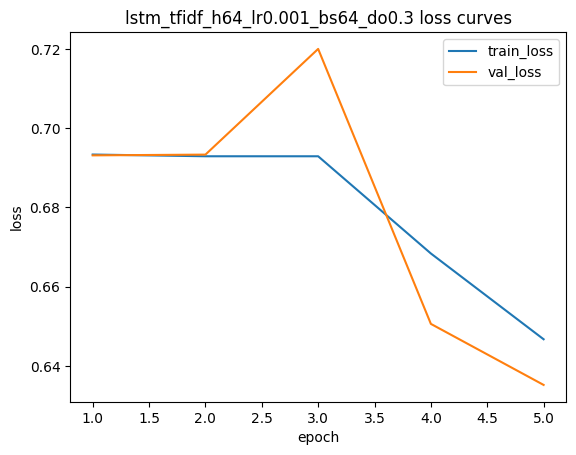


RUN: lstm_tfidf_h64_lr0.0005_bs64_do0.3
Epoch 1/5 | train loss 0.6934 | val loss 0.6931 | val acc 0.5020 | val f1 0.0528
Epoch 2/5 | train loss 0.6932 | val loss 0.6930 | val acc 0.5044 | val f1 0.6600
Epoch 3/5 | train loss 0.6940 | val loss 0.6936 | val acc 0.5011 | val f1 0.0197
Epoch 4/5 | train loss 0.6925 | val loss 0.6926 | val acc 0.5110 | val f1 0.6570
Early stopping (no val F1 improvement for 2 epochs).
TEST | loss 0.6930 acc 0.5017 prec 0.5009 rec 0.9604 f1 0.6584
Confusion matrix:
 [[ 215 4785]
 [ 198 4802]]


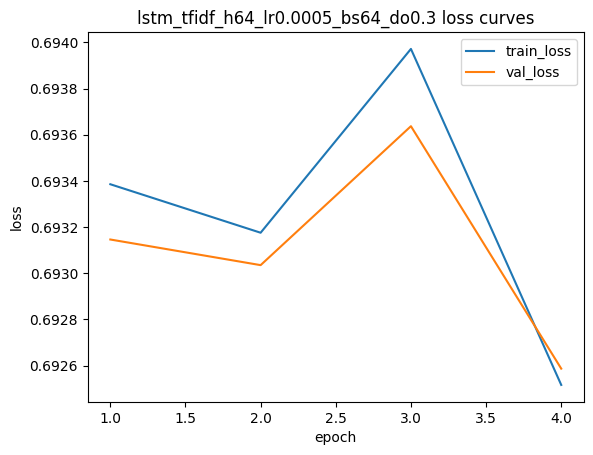


RUN: lstm_tfidf_h128_lr0.001_bs64_do0.3
Epoch 1/5 | train loss 0.6932 | val loss 0.6934 | val acc 0.5010 | val f1 0.0509
Epoch 2/5 | train loss 0.6928 | val loss 0.6930 | val acc 0.5045 | val f1 0.1752
Epoch 3/5 | train loss 0.6916 | val loss 0.6876 | val acc 0.5296 | val f1 0.3189
Epoch 4/5 | train loss 0.6613 | val loss 0.6360 | val acc 0.6659 | val f1 0.6627
Epoch 5/5 | train loss 0.6277 | val loss 0.6249 | val acc 0.6797 | val f1 0.6741
TEST | loss 0.6280 acc 0.6754 prec 0.6838 rec 0.6526 f1 0.6678
Confusion matrix:
 [[3491 1509]
 [1737 3263]]


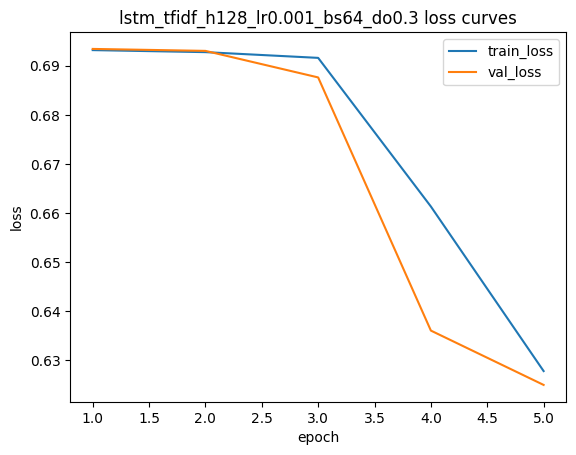


RUN: lstm_tfidf_h128_lr0.0005_bs64_do0.3
Epoch 1/5 | train loss 0.6932 | val loss 0.6932 | val acc 0.5001 | val f1 0.6666
Epoch 2/5 | train loss 0.6930 | val loss 0.6932 | val acc 0.5025 | val f1 0.0901
Epoch 3/5 | train loss 0.6922 | val loss 0.6924 | val acc 0.5065 | val f1 0.6618
Early stopping (no val F1 improvement for 2 epochs).
TEST | loss 0.6932 acc 0.4999 prec 0.4999 rec 0.9992 f1 0.6664
Confusion matrix:
 [[   3 4997]
 [   4 4996]]


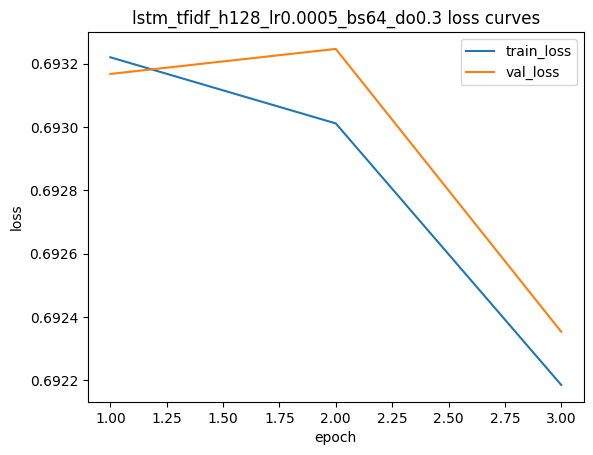


RUN: bilstm_tfidf_h64_lr0.001_bs64_do0.3
Epoch 1/5 | train loss 0.6835 | val loss 0.6325 | val acc 0.6405 | val f1 0.5501
Epoch 2/5 | train loss 0.5666 | val loss 0.5028 | val acc 0.7631 | val f1 0.7458
Epoch 3/5 | train loss 0.4403 | val loss 0.4272 | val acc 0.8153 | val f1 0.8148
Epoch 4/5 | train loss 0.3766 | val loss 0.5305 | val acc 0.7907 | val f1 0.7685
Epoch 5/5 | train loss 0.3353 | val loss 0.4660 | val acc 0.8221 | val f1 0.8357
TEST | loss 0.4420 acc 0.8293 prec 0.7869 rec 0.9032 f1 0.8410
Confusion matrix:
 [[3777 1223]
 [ 484 4516]]


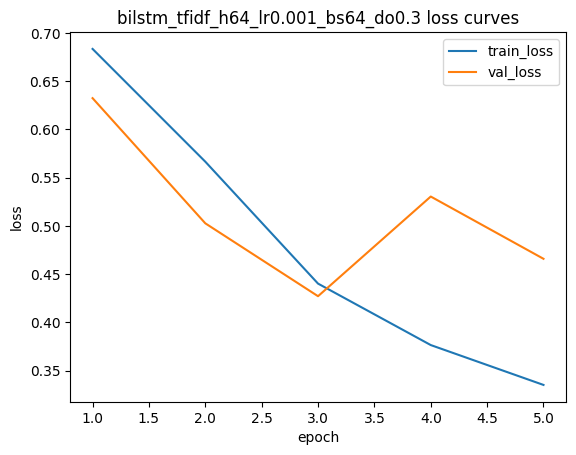


RUN: bilstm_tfidf_h64_lr0.0005_bs64_do0.3
Epoch 1/5 | train loss 0.6940 | val loss 0.6920 | val acc 0.5214 | val f1 0.1721
Epoch 2/5 | train loss 0.6593 | val loss 0.6034 | val acc 0.6940 | val f1 0.7038
Epoch 3/5 | train loss 0.5503 | val loss 0.5428 | val acc 0.7392 | val f1 0.7603
Epoch 4/5 | train loss 0.4702 | val loss 0.4722 | val acc 0.7699 | val f1 0.7476
Epoch 5/5 | train loss 0.4060 | val loss 0.4359 | val acc 0.7947 | val f1 0.7794
TEST | loss 0.4365 acc 0.7966 prec 0.8452 rec 0.7262 f1 0.7812
Confusion matrix:
 [[4335  665]
 [1369 3631]]


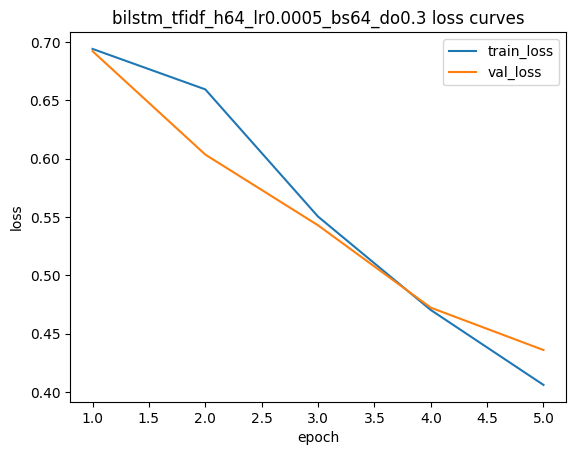


RUN: bilstm_tfidf_h128_lr0.001_bs64_do0.3
Epoch 1/5 | train loss 0.6924 | val loss 0.6577 | val acc 0.5938 | val f1 0.4312
Epoch 2/5 | train loss 0.6030 | val loss 0.5650 | val acc 0.7258 | val f1 0.6954
Epoch 3/5 | train loss 0.4788 | val loss 0.4947 | val acc 0.7924 | val f1 0.8080
Epoch 4/5 | train loss 0.3951 | val loss 0.4613 | val acc 0.7916 | val f1 0.8098
Epoch 5/5 | train loss 0.3583 | val loss 0.4038 | val acc 0.8351 | val f1 0.8351
TEST | loss 0.4134 acc 0.8283 prec 0.8314 rec 0.8236 f1 0.8275
Confusion matrix:
 [[4165  835]
 [ 882 4118]]


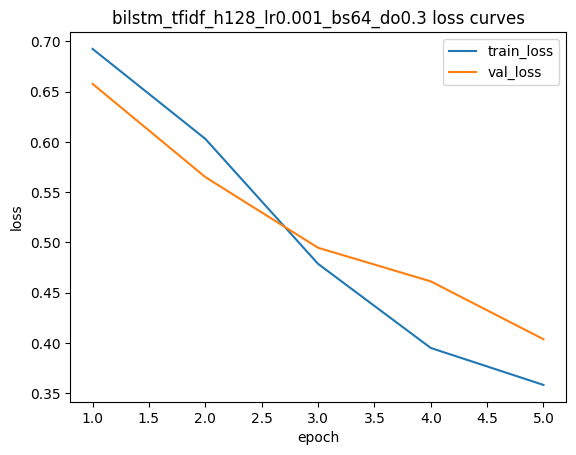


RUN: bilstm_tfidf_h128_lr0.0005_bs64_do0.3
Epoch 1/5 | train loss 0.6892 | val loss 0.6826 | val acc 0.5766 | val f1 0.4280
Epoch 2/5 | train loss 0.6129 | val loss 0.5563 | val acc 0.7314 | val f1 0.7397
Epoch 3/5 | train loss 0.5098 | val loss 0.5191 | val acc 0.7501 | val f1 0.7836
Epoch 4/5 | train loss 0.4652 | val loss 1.0211 | val acc 0.6374 | val f1 0.7273
Epoch 5/5 | train loss 0.4214 | val loss 0.4313 | val acc 0.8136 | val f1 0.8213
TEST | loss 0.4316 acc 0.8103 prec 0.7893 rec 0.8466 f1 0.8169
Confusion matrix:
 [[3870 1130]
 [ 767 4233]]


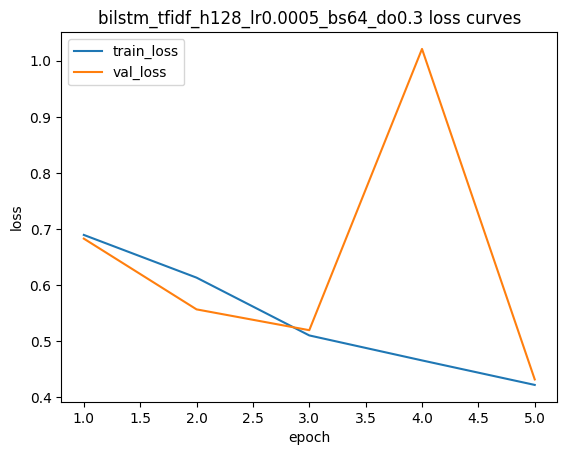


RUN: lstm_word2vec_h64_lr0.001_bs64_do0.3


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 1/5 | train loss 0.6439 | val loss 0.5620 | val acc 0.7469 | val f1 0.7145


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 2/5 | train loss 0.5250 | val loss 0.5005 | val acc 0.7956 | val f1 0.7953


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 3/5 | train loss 0.4593 | val loss 0.4195 | val acc 0.8369 | val f1 0.8377


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 4/5 | train loss 0.3754 | val loss 0.4189 | val acc 0.8489 | val f1 0.8401


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 5/5 | train loss 0.3220 | val loss 0.3800 | val acc 0.8568 | val f1 0.8552


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


TEST | loss 0.3783 acc 0.8568 prec 0.8703 rec 0.8386 f1 0.8541
Confusion matrix:
 [[4375  625]
 [ 807 4193]]


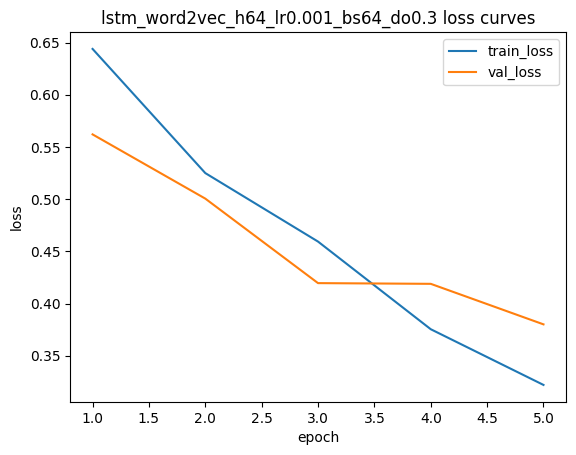


RUN: lstm_word2vec_h64_lr0.0005_bs64_do0.3


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 1/5 | train loss 0.6073 | val loss 0.4963 | val acc 0.7956 | val f1 0.8079


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 2/5 | train loss 0.4538 | val loss 0.4813 | val acc 0.8020 | val f1 0.7755


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 3/5 | train loss 0.3850 | val loss 0.4656 | val acc 0.8171 | val f1 0.8350


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 4/5 | train loss 0.3326 | val loss 0.3990 | val acc 0.8490 | val f1 0.8401


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 5/5 | train loss 0.2909 | val loss 0.3997 | val acc 0.8551 | val f1 0.8473


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


TEST | loss 0.4095 acc 0.8533 prec 0.8999 rec 0.7950 f1 0.8442
Confusion matrix:
 [[4558  442]
 [1025 3975]]


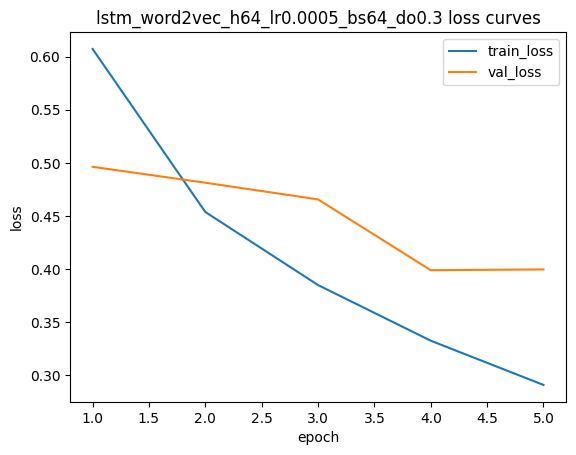


RUN: lstm_word2vec_h128_lr0.001_bs64_do0.3


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 1/5 | train loss 0.5634 | val loss 0.4820 | val acc 0.8113 | val f1 0.8171


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 2/5 | train loss 0.3697 | val loss 0.4383 | val acc 0.8379 | val f1 0.8318


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 3/5 | train loss 0.3052 | val loss 0.4564 | val acc 0.8439 | val f1 0.8492


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 4/5 | train loss 0.2782 | val loss 0.4826 | val acc 0.8339 | val f1 0.8318


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 5/5 | train loss 0.2498 | val loss 0.4233 | val acc 0.8435 | val f1 0.8389
Early stopping (no val F1 improvement for 2 epochs).


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


TEST | loss 0.4472 acc 0.8506 prec 0.8300 rec 0.8818 f1 0.8551
Confusion matrix:
 [[4097  903]
 [ 591 4409]]


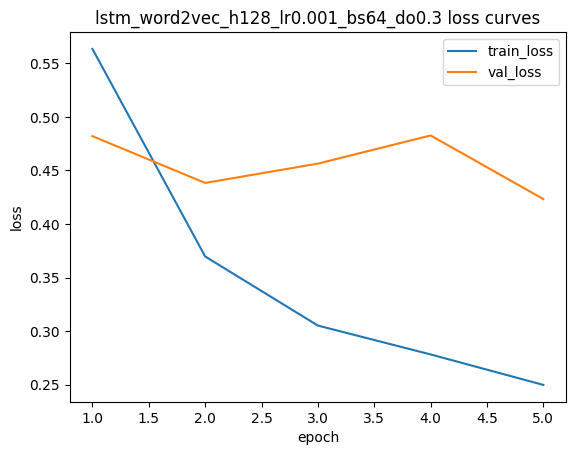


RUN: lstm_word2vec_h128_lr0.0005_bs64_do0.3


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 1/5 | train loss 0.5485 | val loss 0.4651 | val acc 0.8215 | val f1 0.8209


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 2/5 | train loss 0.3761 | val loss 0.4440 | val acc 0.8369 | val f1 0.8333


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 3/5 | train loss 0.3053 | val loss 0.4787 | val acc 0.8363 | val f1 0.8221


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 4/5 | train loss 0.2698 | val loss 0.4373 | val acc 0.8504 | val f1 0.8465


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 5/5 | train loss 0.2413 | val loss 0.4794 | val acc 0.8485 | val f1 0.8606


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


TEST | loss 0.4880 acc 0.8394 prec 0.7893 rec 0.9260 f1 0.8522
Confusion matrix:
 [[3764 1236]
 [ 370 4630]]


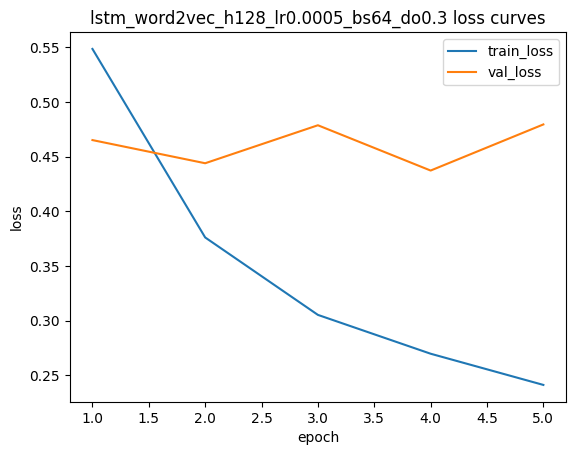


RUN: bilstm_word2vec_h64_lr0.001_bs64_do0.3


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 1/5 | train loss 0.4121 | val loss 0.3749 | val acc 0.8605 | val f1 0.8629


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 2/5 | train loss 0.2178 | val loss 0.3861 | val acc 0.8609 | val f1 0.8570


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 3/5 | train loss 0.1740 | val loss 0.3806 | val acc 0.8725 | val f1 0.8748


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 4/5 | train loss 0.1386 | val loss 0.4125 | val acc 0.8759 | val f1 0.8768


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 5/5 | train loss 0.1089 | val loss 0.4301 | val acc 0.8688 | val f1 0.8701


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


TEST | loss 0.3995 acc 0.8791 prec 0.8753 rec 0.8842 f1 0.8797
Confusion matrix:
 [[4370  630]
 [ 579 4421]]


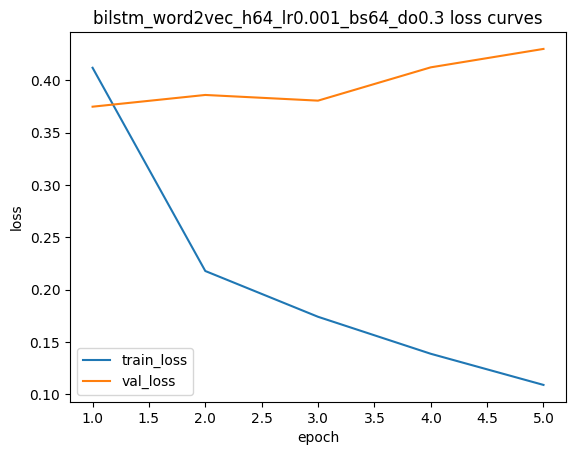


RUN: bilstm_word2vec_h64_lr0.0005_bs64_do0.3


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 1/5 | train loss 0.4366 | val loss 0.3364 | val acc 0.8640 | val f1 0.8671


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 2/5 | train loss 0.2297 | val loss 0.3350 | val acc 0.8750 | val f1 0.8720


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 3/5 | train loss 0.1521 | val loss 0.3815 | val acc 0.8788 | val f1 0.8770


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 4/5 | train loss 0.1203 | val loss 0.4382 | val acc 0.8742 | val f1 0.8722


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 5/5 | train loss 0.0944 | val loss 0.4364 | val acc 0.8786 | val f1 0.8771


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


TEST | loss 0.4576 acc 0.8727 prec 0.8861 rec 0.8554 f1 0.8705
Confusion matrix:
 [[4450  550]
 [ 723 4277]]


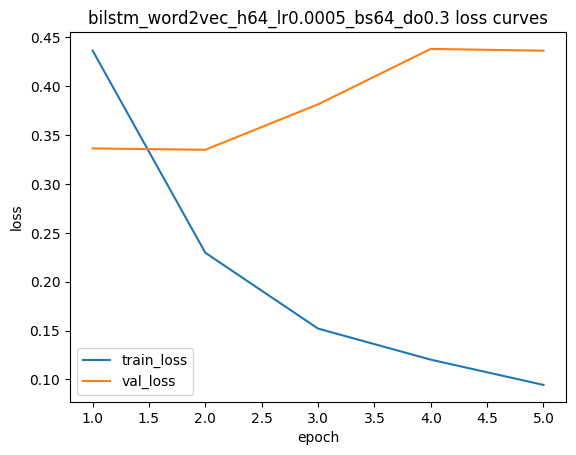


RUN: bilstm_word2vec_h128_lr0.001_bs64_do0.3


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 1/5 | train loss 0.3548 | val loss 0.3416 | val acc 0.8749 | val f1 0.8732


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 2/5 | train loss 0.1494 | val loss 0.3777 | val acc 0.8770 | val f1 0.8768


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 3/5 | train loss 0.0985 | val loss 0.3922 | val acc 0.8735 | val f1 0.8766


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 4/5 | train loss 0.0705 | val loss 0.4510 | val acc 0.8716 | val f1 0.8703
Early stopping (no val F1 improvement for 2 epochs).


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


TEST | loss 0.3724 acc 0.8833 prec 0.8860 rec 0.8798 f1 0.8829
Confusion matrix:
 [[4434  566]
 [ 601 4399]]


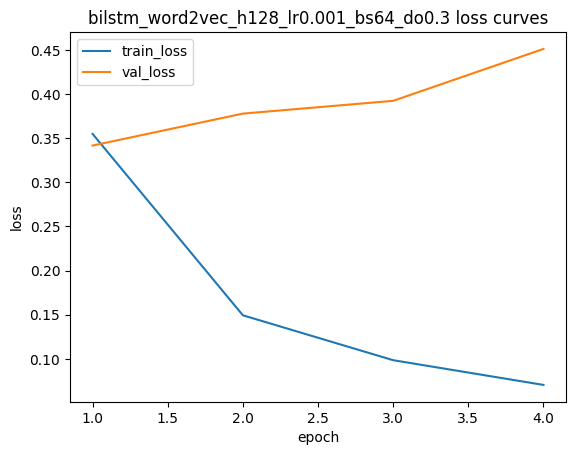


RUN: bilstm_word2vec_h128_lr0.0005_bs64_do0.3


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 1/5 | train loss 0.3738 | val loss 0.3288 | val acc 0.8620 | val f1 0.8636


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 2/5 | train loss 0.1670 | val loss 0.4043 | val acc 0.8674 | val f1 0.8732


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 3/5 | train loss 0.1125 | val loss 0.4135 | val acc 0.8766 | val f1 0.8790


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 4/5 | train loss 0.0888 | val loss 0.4337 | val acc 0.8695 | val f1 0.8754


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 5/5 | train loss 0.0666 | val loss 0.4415 | val acc 0.8732 | val f1 0.8739
Early stopping (no val F1 improvement for 2 epochs).


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


TEST | loss 0.4141 acc 0.8768 prec 0.8668 rec 0.8904 f1 0.8785
Confusion matrix:
 [[4316  684]
 [ 548 4452]]


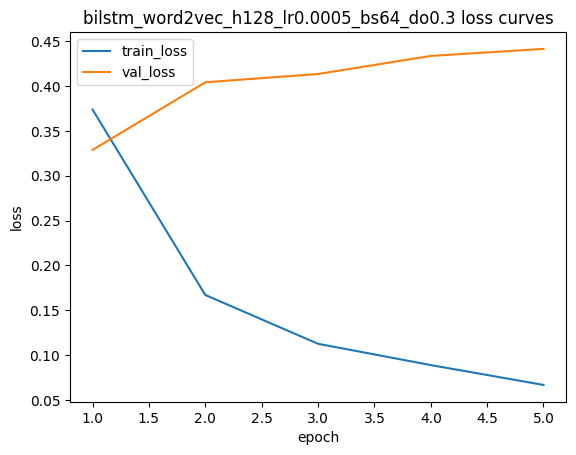


RUN: lstm_glove_h64_lr0.001_bs64_do0.3


NameError: name 'embedding_tensor_glove' is not defined

In [17]:
from itertools import product

os.makedirs("models", exist_ok=True)
os.makedirs("figures", exist_ok=True)

EMBEDDINGS = ["tfidf", "word2vec", "glove"]
BIDIRS     = [False, True]   
HIDDENS    = [64, 128]
LRS        = [1e-3, 5e-4]
BATCHES    = [64]
DROPOUTS   = [0.3]
EPOCHS     = 5
NUM_LAYERS = 1

def make_embedding_layer(emb_name: str):
    if emb_name == "word2vec":
        return nn.Embedding.from_pretrained(embedding_tensor_w2v, freeze=False, padding_idx=PAD_IDX)
    if emb_name == "glove":
        return nn.Embedding.from_pretrained(embedding_tensor_glove, freeze=False, padding_idx=PAD_IDX)
    raise ValueError("Use LSTM_TFIDFSeq for tfidf")

results = []

for emb, bi, h, lr, bs, do in product(EMBEDDINGS, BIDIRS, HIDDENS, LRS, BATCHES, DROPOUTS):
    run_name = f"{'bilstm' if bi else 'lstm'}_{emb}_h{h}_lr{lr}_bs{bs}_do{do}"
    print("\n" + "="*90)
    print("RUN:", run_name)

    train_loader, val_loader, test_loader = make_loaders(train_df, val_df, test_df, batch_size=bs)

    if emb == "tfidf":
        train_loader_t, val_loader_t, test_loader_t = make_tfidfseq_loaders(train_df, val_df, test_df, batch_size=bs)
        model = LSTM_TFIDFSeq(vocab_size=len(itos), embed_dim=EMBED_DIM, hidden_dim=h,
                             pad_idx=PAD_IDX, num_layers=NUM_LAYERS, bidirectional=bi, dropout=do)
        model, history = fit_model_tfidf(model, train_loader_t, val_loader_t, device,
                                         epochs=EPOCHS, lr=lr, patience=2)
        test_m = test_model_tfidf(model, test_loader_t, device)
        plot_history(history, title=f"{run_name} loss curves")
    else:
        emb_layer = make_embedding_layer(emb)
        model = LSTM_Emb(embedding_layer=emb_layer, hidden_dim=h, num_layers=NUM_LAYERS,
                         bidirectional=bi, dropout=do)
        model, history = fit_model(model, train_loader, val_loader, device,
                                   epochs=EPOCHS, lr=lr, patience=2)
        test_m = test_model(model, test_loader, device)
        plot_history(history, title=f"{run_name} loss curves")

    model_path = os.path.join("models", run_name + ".pt")
    cfg_path   = os.path.join("models", run_name + ".json")
    torch.save(model.state_dict(), model_path)

    cfg = {
        "run_name": run_name,
        "embedding": emb,
        "bidirectional": bi,
        "hidden_dim": h,
        "lr": lr,
        "batch_size": bs,
        "dropout": do,
        "epochs": EPOCHS,
        "num_layers": NUM_LAYERS,
        "max_len": MAX_LEN,
        "max_vocab": MAX_VOCAB,
        "embed_dim": EMBED_DIM,
    }
    with open(cfg_path, "w", encoding="utf-8") as f:
        json.dump(cfg, f, indent=2)

    results.append({**cfg, **{f"test_{k}": v for k,v in test_m.items() if k != "cm"}})

results_df = pd.DataFrame(results).sort_values("test_f1", ascending=False)
results_df.head(10)

In [18]:
import os
print("glove zip exists:", os.path.exists("glove.6B.zip"))
print("glove txt exists:", os.path.exists("glove.6B.100d.txt"))

glove zip exists: True
glove txt exists: False


In [19]:
import zipfile, os

GLOVE_ZIP = "glove.6B.zip"
with zipfile.ZipFile(GLOVE_ZIP, "r") as z:
    z.extractall(".")  

print("glove.6B.100d.txt exists now:", os.path.exists("glove.6B.100d.txt"))

glove.6B.100d.txt exists now: True


In [20]:
import numpy as np
import torch

GLOVE_TXT = "glove.6B.100d.txt"
EMB_DIM = 100

glove = {}
with open(GLOVE_TXT, "r", encoding="utf-8") as f:
    for line in f:
        parts = line.rstrip().split(" ")
        word = parts[0]
        vec = np.array(parts[1:], dtype=np.float32)
        if vec.shape[0] == EMB_DIM:
            glove[word] = vec

embedding_matrix = np.random.normal(0, 0.1, (len(itos), EMB_DIM)).astype(np.float32)
embedding_matrix[PAD_IDX] = 0.0

hits = 0
for i, w in enumerate(itos):
    if w in glove:
        embedding_matrix[i] = glove[w]
        hits += 1

embedding_tensor_glove = torch.tensor(embedding_matrix, dtype=torch.float32)
print("GloVe hits:", hits, "/", len(itos))

GloVe hits: 19729 / 20000



RUN: lstm_glove_h64_lr0.001_bs64_do0.3


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 1/5 | train loss 0.6853 | val loss 0.6780 | val acc 0.5560 | val f1 0.6373


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 2/5 | train loss 0.5750 | val loss 0.4582 | val acc 0.8207 | val f1 0.8178


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 3/5 | train loss 0.4104 | val loss 0.4130 | val acc 0.8333 | val f1 0.8154


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 4/5 | train loss 0.3286 | val loss 0.4081 | val acc 0.8574 | val f1 0.8531


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 5/5 | train loss 0.2750 | val loss 0.3741 | val acc 0.8598 | val f1 0.8646


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


TEST | loss 0.3781 acc 0.8575 prec 0.8386 rec 0.8854 f1 0.8614
Confusion matrix:
 [[4148  852]
 [ 573 4427]]


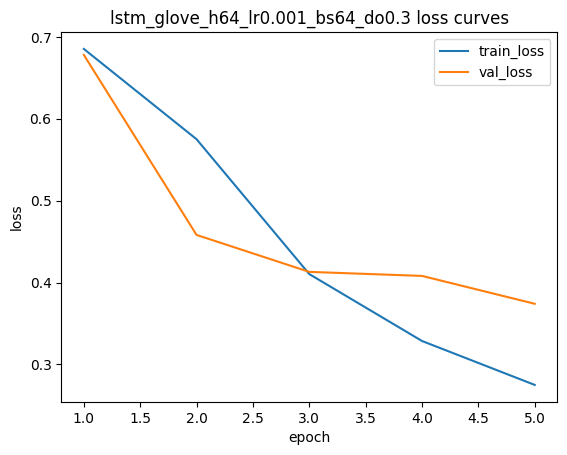


RUN: lstm_glove_h64_lr0.0005_bs64_do0.3


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 1/5 | train loss 0.5575 | val loss 0.4240 | val acc 0.8355 | val f1 0.8298


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 2/5 | train loss 0.3070 | val loss 0.3939 | val acc 0.8614 | val f1 0.8658


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 3/5 | train loss 0.2557 | val loss 0.4249 | val acc 0.8624 | val f1 0.8609


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 4/5 | train loss 0.2441 | val loss 0.4477 | val acc 0.8600 | val f1 0.8669


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 5/5 | train loss 0.2178 | val loss 0.4546 | val acc 0.8646 | val f1 0.8671


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


TEST | loss 0.4585 acc 0.8636 prec 0.8563 rec 0.8738 f1 0.8650
Confusion matrix:
 [[4267  733]
 [ 631 4369]]


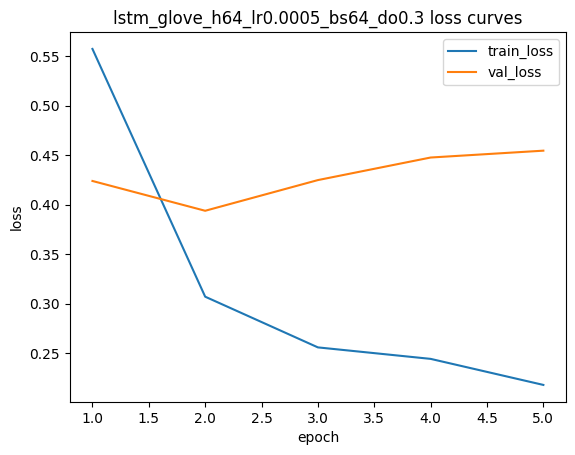


RUN: lstm_glove_h128_lr0.001_bs64_do0.3


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 1/5 | train loss 0.5052 | val loss 0.4258 | val acc 0.8491 | val f1 0.8366


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 2/5 | train loss 0.2567 | val loss 0.4361 | val acc 0.8639 | val f1 0.8641


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 3/5 | train loss 0.2316 | val loss 0.4557 | val acc 0.8560 | val f1 0.8531


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 4/5 | train loss 0.2246 | val loss 0.5074 | val acc 0.8590 | val f1 0.8564
Early stopping (no val F1 improvement for 2 epochs).


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


TEST | loss 0.4478 acc 0.8590 prec 0.8663 rec 0.8490 f1 0.8576
Confusion matrix:
 [[4345  655]
 [ 755 4245]]


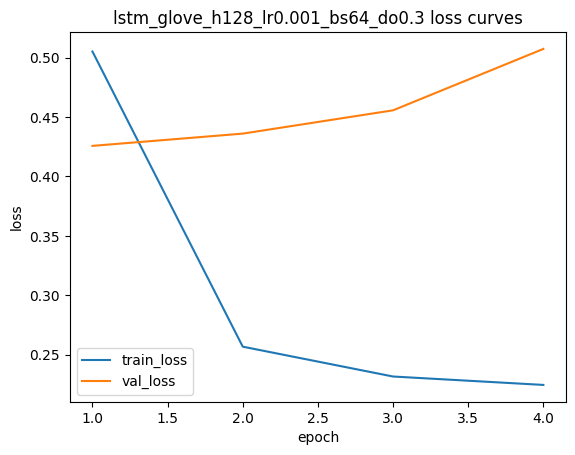


RUN: lstm_glove_h128_lr0.0005_bs64_do0.3


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 1/5 | train loss 0.5232 | val loss 0.5044 | val acc 0.8003 | val f1 0.8225


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 2/5 | train loss 0.3180 | val loss 0.4318 | val acc 0.8397 | val f1 0.8471


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 3/5 | train loss 0.2486 | val loss 0.4311 | val acc 0.8676 | val f1 0.8677


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 4/5 | train loss 0.2197 | val loss 0.4301 | val acc 0.8638 | val f1 0.8645


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 5/5 | train loss 0.2138 | val loss 0.4459 | val acc 0.8634 | val f1 0.8678


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


TEST | loss 0.4476 acc 0.8593 prec 0.8446 rec 0.8806 f1 0.8622
Confusion matrix:
 [[4190  810]
 [ 597 4403]]


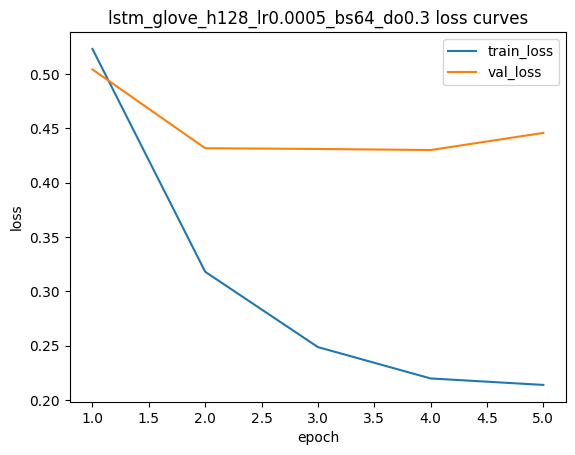


RUN: bilstm_glove_h64_lr0.001_bs64_do0.3


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 1/5 | train loss 0.3833 | val loss 0.3267 | val acc 0.8770 | val f1 0.8757


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 2/5 | train loss 0.1713 | val loss 0.3465 | val acc 0.8760 | val f1 0.8758


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 3/5 | train loss 0.1244 | val loss 0.4128 | val acc 0.8772 | val f1 0.8792


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 4/5 | train loss 0.0921 | val loss 0.4211 | val acc 0.8735 | val f1 0.8778


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 5/5 | train loss 0.0651 | val loss 0.5626 | val acc 0.8669 | val f1 0.8714
Early stopping (no val F1 improvement for 2 epochs).


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


TEST | loss 0.4161 acc 0.8783 prec 0.8733 rec 0.8850 f1 0.8791
Confusion matrix:
 [[4358  642]
 [ 575 4425]]


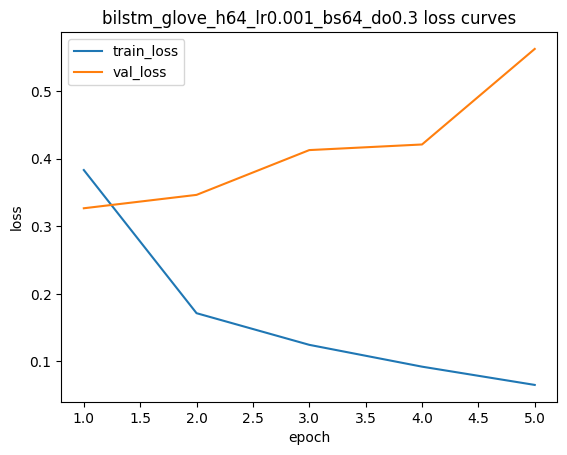


RUN: bilstm_glove_h64_lr0.0005_bs64_do0.3


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 1/5 | train loss 0.4022 | val loss 0.3370 | val acc 0.8621 | val f1 0.8627


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 2/5 | train loss 0.1817 | val loss 0.3920 | val acc 0.8754 | val f1 0.8780


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 3/5 | train loss 0.1083 | val loss 0.4339 | val acc 0.8738 | val f1 0.8757


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 4/5 | train loss 0.0857 | val loss 0.5331 | val acc 0.8701 | val f1 0.8712
Early stopping (no val F1 improvement for 2 epochs).


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


TEST | loss 0.3797 acc 0.8793 prec 0.8715 rec 0.8898 f1 0.8806
Confusion matrix:
 [[4344  656]
 [ 551 4449]]


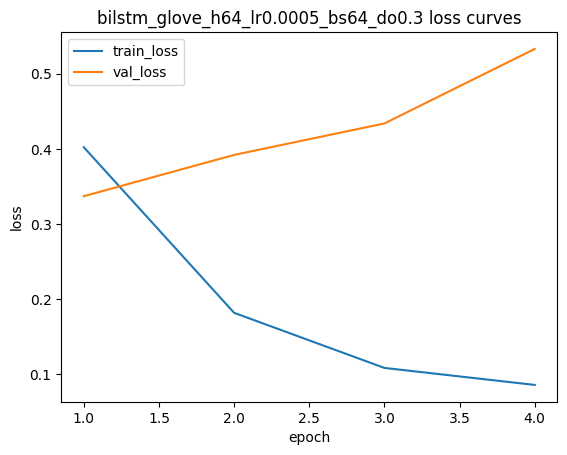


RUN: bilstm_glove_h128_lr0.001_bs64_do0.3


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 1/5 | train loss 0.3161 | val loss 0.4190 | val acc 0.8549 | val f1 0.8405


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 2/5 | train loss 0.1235 | val loss 0.4154 | val acc 0.8724 | val f1 0.8696


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 3/5 | train loss 0.0830 | val loss 0.4585 | val acc 0.8721 | val f1 0.8747


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 4/5 | train loss 0.0596 | val loss 0.4608 | val acc 0.8656 | val f1 0.8716


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 5/5 | train loss 0.0436 | val loss 0.5328 | val acc 0.8671 | val f1 0.8680
Early stopping (no val F1 improvement for 2 epochs).


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


TEST | loss 0.4608 acc 0.8710 prec 0.8633 rec 0.8816 f1 0.8724
Confusion matrix:
 [[4302  698]
 [ 592 4408]]


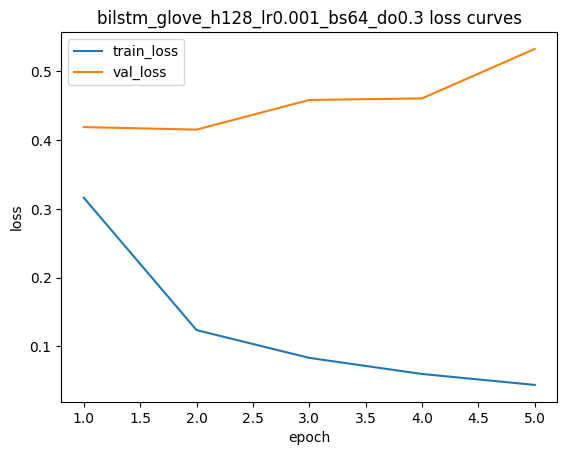


RUN: bilstm_glove_h128_lr0.0005_bs64_do0.3


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 1/5 | train loss 0.3709 | val loss 0.3284 | val acc 0.8725 | val f1 0.8727


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 2/5 | train loss 0.1260 | val loss 0.4767 | val acc 0.8722 | val f1 0.8745


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 3/5 | train loss 0.0670 | val loss 0.5018 | val acc 0.8698 | val f1 0.8714


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 4/5 | train loss 0.0506 | val loss 0.5000 | val acc 0.8685 | val f1 0.8711
Early stopping (no val F1 improvement for 2 epochs).


c:\Users\Joud\Desktop\inmind\presentation_2\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


TEST | loss 0.4768 acc 0.8724 prec 0.8652 rec 0.8822 f1 0.8736
Confusion matrix:
 [[4313  687]
 [ 589 4411]]


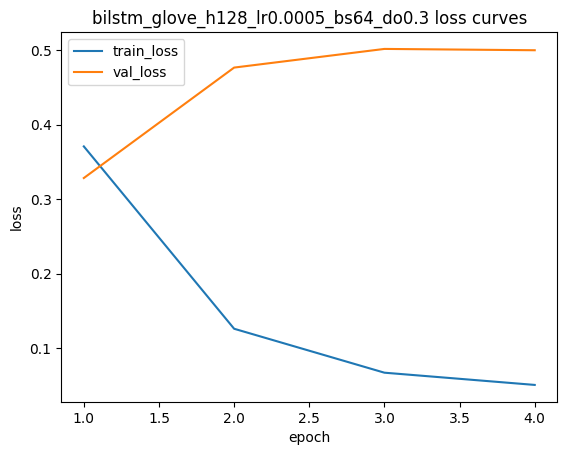

,run_name,embedding,bidirectional,hidden_dim,lr,batch_size,dropout,epochs,num_layers,max_len,max_vocab,embed_dim,test_acc,test_precision,test_recall,test_f1,test_loss
5,bilstm_glove_h64_lr0.0005_bs64_do0.3,glove,True,64,0.0005,64,0.3,5,1,256,20000,100,0.8793,0.871499,0.8898,0.880554,0.379694
4,bilstm_glove_h64_lr0.001_bs64_do0.3,glove,True,64,0.0010,64,0.3,5,1,256,20000,100,0.8783,0.873298,0.8850,0.879110,0.416084
7,bilstm_glove_h128_lr0.0005_bs64_do0.3,glove,True,128,0.0005,64,0.3,5,1,256,20000,100,0.8724,0.865241,0.8822,0.873638,0.476839
6,bilstm_glove_h128_lr0.001_bs64_do0.3,glove,True,128,0.0010,64,0.3,5,1,256,20000,100,0.8710,0.863298,0.8816,0.872353,0.460816
1,lstm_glove_h64_lr0.0005_bs64_do0.3,glove,False,64,0.0005,64,0.3,5,1,256,20000,100,0.8636,0.856331,0.8738,0.864977,0.458523
3,lstm_glove_h128_lr0.0005_bs64_do0.3,glove,False,128,0.0005,64,0.3,5,1,256,20000,100,0.8593,0.844619,0.8806,0.862234,0.447582
0,lstm_glove_h64_lr0.001_bs64_do0.3,glove,False,64,0.0010,64,0.3,5,1,256,20000,100,0.8575,0.838606,0.8854,0.861368,0.378079
2,lstm_glove_h128_lr0.001_bs64_do0.3,glove,False,128,0.0010,64,0.3,5,1,256,20000,100,0.8590,0.866327,0.8490,0.857576,0.447783


In [22]:
from itertools import product

os.makedirs("models", exist_ok=True)
os.makedirs("figures", exist_ok=True)

EMBEDDINGS = ["glove"]
BIDIRS     = [False, True]   
HIDDENS    = [64, 128]
LRS        = [1e-3, 5e-4]
BATCHES    = [64]
DROPOUTS   = [0.3]
EPOCHS     = 5
NUM_LAYERS = 1

def make_embedding_layer(emb_name: str):
    if emb_name == "word2vec":
        return nn.Embedding.from_pretrained(embedding_tensor_w2v, freeze=False, padding_idx=PAD_IDX)
    if emb_name == "glove":
        return nn.Embedding.from_pretrained(embedding_tensor_glove, freeze=False, padding_idx=PAD_IDX)
    raise ValueError("Use LSTM_TFIDFSeq for tfidf")

results = []

for emb, bi, h, lr, bs, do in product(EMBEDDINGS, BIDIRS, HIDDENS, LRS, BATCHES, DROPOUTS):
    run_name = f"{'bilstm' if bi else 'lstm'}_{emb}_h{h}_lr{lr}_bs{bs}_do{do}"
    print("\n" + "="*90)
    print("RUN:", run_name)

    train_loader, val_loader, test_loader = make_loaders(train_df, val_df, test_df, batch_size=bs)

    if emb == "tfidf":
        train_loader_t, val_loader_t, test_loader_t = make_tfidfseq_loaders(train_df, val_df, test_df, batch_size=bs)
        model = LSTM_TFIDFSeq(vocab_size=len(itos), embed_dim=EMBED_DIM, hidden_dim=h,
                             pad_idx=PAD_IDX, num_layers=NUM_LAYERS, bidirectional=bi, dropout=do)
        model, history = fit_model_tfidf(model, train_loader_t, val_loader_t, device,
                                         epochs=EPOCHS, lr=lr, patience=2)
        test_m = test_model_tfidf(model, test_loader_t, device)
        plot_history(history, title=f"{run_name} loss curves")
    else:
        emb_layer = make_embedding_layer(emb)
        model = LSTM_Emb(embedding_layer=emb_layer, hidden_dim=h, num_layers=NUM_LAYERS,
                         bidirectional=bi, dropout=do)
        model, history = fit_model(model, train_loader, val_loader, device,
                                   epochs=EPOCHS, lr=lr, patience=2)
        test_m = test_model(model, test_loader, device)
        plot_history(history, title=f"{run_name} loss curves")

    model_path = os.path.join("models", run_name + ".pt")
    cfg_path   = os.path.join("models", run_name + ".json")
    torch.save(model.state_dict(), model_path)

    cfg = {
        "run_name": run_name,
        "embedding": emb,
        "bidirectional": bi,
        "hidden_dim": h,
        "lr": lr,
        "batch_size": bs,
        "dropout": do,
        "epochs": EPOCHS,
        "num_layers": NUM_LAYERS,
        "max_len": MAX_LEN,
        "max_vocab": MAX_VOCAB,
        "embed_dim": EMBED_DIM,
    }
    with open(cfg_path, "w", encoding="utf-8") as f:
        json.dump(cfg, f, indent=2)

    results.append({**cfg, **{f"test_{k}": v for k,v in test_m.items() if k != "cm"}})

results_df = pd.DataFrame(results).sort_values("test_f1", ascending=False)
results_df.head(10)

In [24]:
import json, os
import numpy as np

os.makedirs("models", exist_ok=True)
tfidf_vocab_py = {str(k): int(v) for k, v in tfidf_vocab.items()}
idf_py = [float(x) for x in np.asarray(idf).ravel()]

with open(os.path.join("models", "tfidf_params.json"), "w", encoding="utf-8") as f:
    json.dump({"vocab": tfidf_vocab_py, "idf": idf_py}, f)

print("Saved:", os.path.exists("models/tfidf_params.json"))

Saved: True


In [25]:
import json
with open("models/tfidf_params.json", "r", encoding="utf-8") as f:
    d = json.load(f)
print(len(d["vocab"]), len(d["idf"]))

20000 20000


In [26]:
vocab_path = os.path.join("models", "vocab.json")
with open(vocab_path, "w", encoding="utf-8") as f:
    json.dump({"itos": itos, "stoi": stoi, "pad_idx": PAD_IDX, "unk_idx": UNK_IDX, "max_len": MAX_LEN}, f, indent=2)

vocab_path

'models\\vocab.json'

In [27]:
best = results_df.iloc[0].to_dict()
best_run = best["run_name"]
best_cfg_path = os.path.join("models", best_run + ".json")
best_model_path = os.path.join("models", best_run + ".pt")

with open(best_cfg_path, "r", encoding="utf-8") as f:
    best_cfg = json.load(f)

def encode_text_to_seq(text: str):
    tokens = preprocess_text(text)
    seq = [stoi.get(t, UNK_IDX) for t in tokens]
    seq = pad_truncate(seq, MAX_LEN, PAD_IDX)
    return torch.tensor(seq, dtype=torch.long).unsqueeze(0)

@torch.no_grad()
def load_best_model_and_predict(texts):
    emb = best_cfg["embedding"]
    bi  = best_cfg["bidirectional"]
    h   = best_cfg["hidden_dim"]
    do  = best_cfg["dropout"]
    nl  = best_cfg["num_layers"]

    if emb == "tfidf":
        model = LSTM_TFIDFSeq(vocab_size=len(itos), embed_dim=EMBED_DIM, hidden_dim=h,
                              pad_idx=PAD_IDX, num_layers=nl, bidirectional=bi, dropout=do)
    else:
        emb_layer = make_embedding_layer(emb)
        model = LSTM_Emb(embedding_layer=emb_layer, hidden_dim=h, num_layers=nl,
                         bidirectional=bi, dropout=do)

    model.load_state_dict(torch.load(best_model_path, map_location=device))
    model = model.to(device).eval()

    probs = []
    for t in texts:
        x = encode_text_to_seq(t).to(device)
        if emb == "tfidf":
            w = torch.tensor(token_tfidf_weights(preprocess_text(t), MAX_LEN), dtype=torch.float32).unsqueeze(0).to(device)
            logit = model(x, w).view(-1)
        else:
            logit = model(x).view(-1)
        p = torch.sigmoid(logit).item()
        probs.append(p)
    return probs

sample_test = test_df.sample(200, random_state=SEED).reset_index(drop=True)
texts = sample_test["text"].tolist()
y_true = sample_test["label"].tolist()
p = load_best_model_and_predict(texts)
preds = [1 if pi >= 0.5 else 0 for pi in p]

errors = [(i, y_true[i], preds[i], p[i], texts[i][:220]) for i in range(len(texts)) if y_true[i] != preds[i]]
print("Errors in sample:", len(errors))
errors[:5]

Errors in sample: 19


[(27,
  1,
  0,
  0.30175748467445374,
  "This movie is apparently intended for a young, evangelical Christian audience as a teaching tool. For that I give it a 7 out of 10 point vote. It's a decent movie to show a youth group, but I don't think it will be very "),
 (41,
  0,
  1,
  0.9868331551551819,
  "I had known Brad Linaweaver at Florida State U in the early 70's when he was an inspiring, inventive writer who I thought was headed for greater glory.<br /><br />And that is why I rented this video. Well, well, well, th"),
 (45,
  0,
  1,
  0.9891085624694824,
  "After having watched Darwin's Nightmare, one must have the impression of Tanzania being a living hell, with its population being quasi-slaves delivering the finest fish to the well-fed Europeans while leaving the fish bo"),
 (53,
  1,
  0,
  0.07314644008874893,
  "I don't know how I would feel if I lived in USA. I would watch some preview scenes, advertisements, I would know, Sidney Pollack directed it, Harrison Ford and Kr